In [1]:
import re
import random
import warnings
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, classification_report, roc_curve,auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from nltk import WordNetLemmatizer

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r'C:\misc\NLP Disaster\train.csv')
test = pd.read_csv(r'C:\misc\NLP Disaster\test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


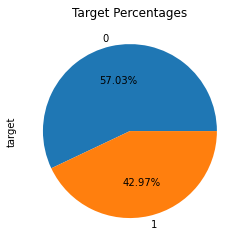

In [4]:
# check distribution of target
train['target'].value_counts().plot(kind = 'pie',title='Target Percentages',autopct='%1.2f%%')
plt.show()

In [5]:
# lower all text
train['text'] = train['text'].str.lower()
train['text'].sample(5)

5787    still rioting in a couple of hours left until ...
3984    slip sliding away - flash floods info for writ...
5770    sweetpea's are running riot at the allotment -...
2138    irony just died a thousand deaths! ???? http:/...
7207    'education is the most powerful weapon which y...
Name: text, dtype: object

In [6]:
# Remove stopwords
stops = set(stopwords.words('english'))
def remove_stops(text):
    return ' '.join([word for word in str(text).split() if word not in stops])
train['text'] = train['text'].apply(lambda x: remove_stops(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])

always try bring heavy. #metal #rt http://t.co/yao1e0xngw
@bbcmtd wholesale markets ablaze http://t.co/lhyxeohy6c


In [7]:
#Not used but remove text with @
'''
def remove_ats(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())
train['text'] = train['text'].apply(lambda x: remove_ats(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])
'''

'\ndef remove_ats(text):\n    return \' \'.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())\ntrain[\'text\'] = train[\'text\'].apply(lambda x: remove_ats(x))\nprint(train[\'text\'].iloc[32])\nprint(train[\'text\'].iloc[31])\n'

In [8]:
# Clean punctuation
eng_punc = string.punctuation
def clean_punct(text):
    trans = str.maketrans('','',eng_punc)
    return text.translate(trans)
train['text'] = train['text'].apply(lambda x: clean_punct(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])

always try bring heavy metal rt httptcoyao1e0xngw
bbcmtd wholesale markets ablaze httptcolhyxeohy6c


In [9]:
# chop url so http can be used as text
def chop_url(text):
    index = text.find('http')
    if index>0:
        return text[:index+4]
    else:
        return text
train['text'] = train['text'].apply(lambda x: chop_url(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])

always try bring heavy metal rt http
bbcmtd wholesale markets ablaze http


In [10]:
# remove numbers
def clean_nums(text):
    return re.sub('[0-9]+','',text)
train['text'] = train['text'].apply(lambda x: clean_nums(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])

always try bring heavy metal rt http
bbcmtd wholesale markets ablaze http


In [11]:
# tokenize
train['text'] = train['text'].apply(lambda x: word_tokenize(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])

['always', 'try', 'bring', 'heavy', 'metal', 'rt', 'http']
['bbcmtd', 'wholesale', 'markets', 'ablaze', 'http']


In [12]:
# not used, but port stemmmer 
'''
ps = PorterStemmer(mode='ORIGINAL_ALGORITHM')
def stem(text):
    text = [ps.stem(word) for word in text]
    return text
train['text'] = train['text'].apply(lambda x: stem(x))
train['text'].head()
'''

"\nps = PorterStemmer(mode='ORIGINAL_ALGORITHM')\ndef stem(text):\n    text = [ps.stem(word) for word in text]\n    return text\ntrain['text'] = train['text'].apply(lambda x: stem(x))\ntrain['text'].head()\n"

In [13]:
# Lemmatize words
lm = WordNetLemmatizer()
def lemmatize(text):
    text = [lm.lemmatize(word) for word in text]
    return text
train['text'] = train['text'].apply(lambda x: lemmatize(x))
print(train['text'].iloc[32])
print(train['text'].iloc[31])


['always', 'try', 'bring', 'heavy', 'metal', 'rt', 'http']
['bbcmtd', 'wholesale', 'market', 'ablaze', 'http']


In [14]:
# Prepare data to be fit through model
train['text'] = train['text'].astype(str)
X = train['text'].values
y = train['target'].values

In [15]:
# Split and into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [16]:
# Use TFIDF for model
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)
print('No, of feature words: ', len(vectorizer.get_feature_names()))

No, of feature words:  52373


In [17]:
# Transform data using vectorizer
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [18]:
#Function to evaluate model
def model_eval(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print ('Training accuracy: %.4f' % model.score(X_train, y_train))
    print ('Training f-1 score: %.4f' % f1_score(y_train, model.predict(X_train)))
    print ('Test accuracy: %.4f' % model.score(X_test, y_test))
    print ('Test f-1 score: %.4f' % f1_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    cf_matrix = confusion_matrix(y_test,y_pred)
    categories = ['Not Disaster','Disaster']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Training accuracy: 0.9021
Training f-1 score: 0.8743
Test accuracy: 0.8011
Test f-1 score: 0.7562
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       859
           1       0.81      0.71      0.76       664

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



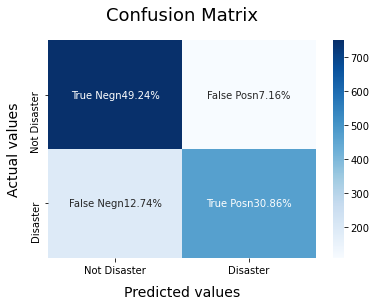

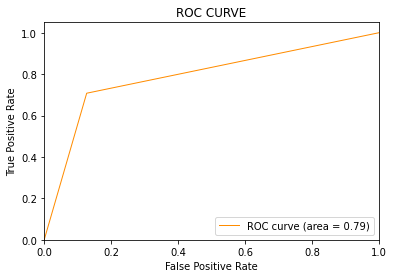

In [19]:
# Logistic Regression model validation
lr = LogisticRegression(max_iter = 100)
model_eval(lr)
y_pred = lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Training accuracy: 0.9824
Training f-1 score: 0.9795
Test accuracy: 0.7866
Test f-1 score: 0.7558
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       859
           1       0.75      0.76      0.76       664

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



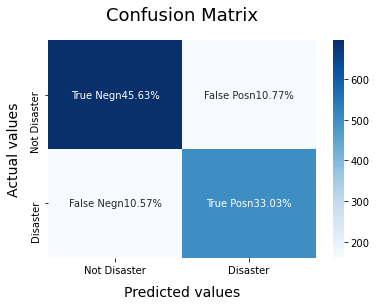

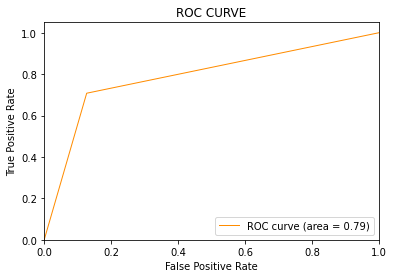

In [20]:
# Passive Aggressive Classifier validation
pac = PassiveAggressiveClassifier(max_iter=1000, loss='squared_hinge')
model_eval(pac)
y_pred = lr.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Deciding to use Passive Aggtessive Classifier since it would be most useful in a stream of tweets 

In [21]:
# Fit model on all data
X = vectorizer.fit_transform(X)
pac.fit(X,y)

PassiveAggressiveClassifier(loss='squared_hinge')

In [22]:
# Clean test data
def clean_test(df):
    df['text'] = df['text'].apply(lambda x: remove_stops(x))
    df['text'] = df['text'].apply(lambda x: clean_punct(x))
    df['text'] = df['text'].apply(lambda x: chop_url(x))
    df['text'] = df['text'].apply(lambda x: clean_nums(x))
    df['text'] = df['text'].apply(lambda x: word_tokenize(x))
    df['text'] = df['text'].apply(lambda x: lemmatize(x))
    return df
test = clean_test(test)

In [23]:
# prep test data for model
test.head()
X_final_test = test['text'].astype(str).values
X_final_test = vectorizer.transform(X_final_test)

In [24]:
# make predictions 
test_pred = pac.predict(X_final_test)

In [25]:
test_pred = pd.Series(data=test_pred,name='target')
return_df = pd.concat([test['id'],test_pred],axis=1)
return_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [26]:
return_df.to_csv(r'C:\misc\NLP Disaster\submission.csv',index=False)

## Let's try it with Logistic Regression too

In [27]:
lr.fit(X,y)
test_pred_lr = lr.predict(X_final_test)
test_pred_lr = pd.Series(data=test_pred_lr,name='target')
return_df_lr = pd.concat([test['id'],test_pred],axis=1)
return_df_lr.to_csv(r'C:\misc\NLP Disaster\submission_lr.csv',index=False)

# Kaggle Results
### Passive Aggressive Classifier: 0.78424
### Logistic Regression: 0.78823